# Donor cell level analysis, T and B cells

**Top Note:** we should consider normalise the library size (labelled as `exp_sum_count` or `total_counts`) with predefined coefficient weight as 1.

$$y \sim NB(\mu, \phi)$$
$$\log(\mu) = w_0 * 1 + w_1 * condition + 1 * total\_counts$$

You may use your implemement and fit this parameter (it should be close enough to 1) or use 
[statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.NegativeBinomial.html)
by setting it as `exposure`:

```Python
NB_glm = sm.discrete.discrete_model.NegativeBinomial(
    obs_y, feature_x,                                                         
    loglike_method = 'nb2', 
    exposure = sample_libsize, 
    offset = None, 
    missing = 'none', 
    check_rank = True
)
```

For negative binomial likelihood, check [aod R package](https://rdrr.io/cran/aod/man/negbin.html).

In [70]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.io import mmread
from statsmodels.discrete.discrete_model import NegativeBinomial
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(1, '../NegabinGLM')

import NegativeBinomial as NB

In [95]:
# create a repository for the data
!mkdir ../write_data
path = '../write_data_donor_T/'

## Load genes

In [2]:
df_genes = pd.read_csv('../data/NPC_NLH-genes.tsv', sep='\t')
df_genes

,gene_names,gene_ids
0,HES5,ENSG00000197921
1,TP73,ENSG00000078900
2,HES2,ENSG00000069812
3,PAX7,ENSG00000009709
4,E2F2,ENSG00000007968
...,...,...
614,OLIG1,ENSG00000184221
615,RUNX1,ENSG00000159216
616,ERG,ENSG00000157554
617,ETS2,ENSG00000157557


## Load donor level T cells

In [3]:
df_donor_T = pd.read_csv('../data/NPC_NLH-Tcell-donorX.tsv', sep='\t', index_col=0)
df_donor_T

,condition,cell_number,total_counts,HES5,TP73,HES2,PAX7,E2F2,RUNX3,TFAP2E,...,TEF,SREBF2,GABPA,BACH1,OLIG2,OLIG1,RUNX1,ERG,ETS2,PKNOX1
patient_ID,,,,,,,,,,,,,,,,,,,,,
1,NPC,1347,4519666.0,0.0,0.0,0.0,0.0,3.0,460.0,6.0,...,6.0,141.0,95.0,124.0,0.0,0.0,177.0,0.0,53.0,76.0
2,NPC,1948,7188569.0,0.0,25.0,0.0,0.0,37.0,1265.0,8.0,...,21.0,159.0,134.0,99.0,0.0,0.0,362.0,0.0,128.0,106.0
3,NPC,3677,5781870.0,0.0,8.0,0.0,0.0,11.0,514.0,5.0,...,10.0,143.0,76.0,88.0,0.0,0.0,283.0,0.0,57.0,64.0
4,NPC,1324,3987246.0,0.0,3.0,0.0,0.0,9.0,603.0,3.0,...,6.0,87.0,80.0,93.0,0.0,0.0,178.0,0.0,45.0,57.0
5,NPC,1567,5188094.0,0.0,15.0,0.0,0.0,37.0,495.0,4.0,...,7.0,193.0,97.0,130.0,0.0,0.0,242.0,0.0,28.0,74.0
9,NPC,4424,20663310.0,1.0,62.0,2.0,0.0,72.0,1971.0,37.0,...,32.0,886.0,410.0,480.0,0.0,0.0,983.0,0.0,226.0,280.0
10,NPC,3320,12679133.0,0.0,13.0,0.0,0.0,25.0,1016.0,11.0,...,32.0,309.0,204.0,178.0,0.0,0.0,545.0,0.0,132.0,156.0
11,NLH,2841,11321356.0,0.0,1.0,0.0,0.0,7.0,657.0,4.0,...,24.0,280.0,191.0,148.0,0.0,0.0,505.0,0.0,121.0,123.0
12,NLH,2393,10087484.0,0.0,3.0,0.0,0.0,16.0,798.0,10.0,...,17.0,319.0,177.0,140.0,0.0,0.0,464.0,0.0,100.0,117.0


In [4]:
X_donor_T = df_donor_T[['condition', 'cell_number', 'total_counts']]
X_donor_T

,condition,cell_number,total_counts
patient_ID,,,
1,NPC,1347,4519666.0
2,NPC,1948,7188569.0
3,NPC,3677,5781870.0
4,NPC,1324,3987246.0
5,NPC,1567,5188094.0
9,NPC,4424,20663310.0
10,NPC,3320,12679133.0
11,NLH,2841,11321356.0
12,NLH,2393,10087484.0


In [5]:
Y_donor_T = df_donor_T[df_donor_T.columns[3:]]
Y_donor_T

,HES5,TP73,HES2,PAX7,E2F2,RUNX3,TFAP2E,MTF1,POU3F1,ZNF684,...,TEF,SREBF2,GABPA,BACH1,OLIG2,OLIG1,RUNX1,ERG,ETS2,PKNOX1
patient_ID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,3.0,460.0,6.0,92.0,12.0,28.0,...,6.0,141.0,95.0,124.0,0.0,0.0,177.0,0.0,53.0,76.0
2,0.0,25.0,0.0,0.0,37.0,1265.0,8.0,143.0,43.0,59.0,...,21.0,159.0,134.0,99.0,0.0,0.0,362.0,0.0,128.0,106.0
3,0.0,8.0,0.0,0.0,11.0,514.0,5.0,76.0,32.0,37.0,...,10.0,143.0,76.0,88.0,0.0,0.0,283.0,0.0,57.0,64.0
4,0.0,3.0,0.0,0.0,9.0,603.0,3.0,76.0,20.0,42.0,...,6.0,87.0,80.0,93.0,0.0,0.0,178.0,0.0,45.0,57.0
5,0.0,15.0,0.0,0.0,37.0,495.0,4.0,55.0,20.0,45.0,...,7.0,193.0,97.0,130.0,0.0,0.0,242.0,0.0,28.0,74.0
9,1.0,62.0,2.0,0.0,72.0,1971.0,37.0,386.0,306.0,168.0,...,32.0,886.0,410.0,480.0,0.0,0.0,983.0,0.0,226.0,280.0
10,0.0,13.0,0.0,0.0,25.0,1016.0,11.0,188.0,92.0,119.0,...,32.0,309.0,204.0,178.0,0.0,0.0,545.0,0.0,132.0,156.0
11,0.0,1.0,0.0,0.0,7.0,657.0,4.0,206.0,15.0,61.0,...,24.0,280.0,191.0,148.0,0.0,0.0,505.0,0.0,121.0,123.0
12,0.0,3.0,0.0,0.0,16.0,798.0,10.0,176.0,18.0,69.0,...,17.0,319.0,177.0,140.0,0.0,0.0,464.0,0.0,100.0,117.0


filter gene with 0 total counts

In [6]:
# filter out genes with zero counts in all cells
Y_donor_T = Y_donor_T.loc[:, (Y_donor_T != 0).any(axis=0)]
Y_donor_T

,HES5,TP73,HES2,E2F2,RUNX3,TFAP2E,MTF1,POU3F1,ZNF684,NFYC,...,SOX10,MAFF,ATF4,TEF,SREBF2,GABPA,BACH1,RUNX1,ETS2,PKNOX1
patient_ID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,3.0,460.0,6.0,92.0,12.0,28.0,235.0,...,0.0,37.0,361.0,6.0,141.0,95.0,124.0,177.0,53.0,76.0
2,0.0,25.0,0.0,37.0,1265.0,8.0,143.0,43.0,59.0,511.0,...,0.0,127.0,598.0,21.0,159.0,134.0,99.0,362.0,128.0,106.0
3,0.0,8.0,0.0,11.0,514.0,5.0,76.0,32.0,37.0,316.0,...,1.0,32.0,399.0,10.0,143.0,76.0,88.0,283.0,57.0,64.0
4,0.0,3.0,0.0,9.0,603.0,3.0,76.0,20.0,42.0,276.0,...,0.0,24.0,330.0,6.0,87.0,80.0,93.0,178.0,45.0,57.0
5,0.0,15.0,0.0,37.0,495.0,4.0,55.0,20.0,45.0,344.0,...,0.0,22.0,342.0,7.0,193.0,97.0,130.0,242.0,28.0,74.0
9,1.0,62.0,2.0,72.0,1971.0,37.0,386.0,306.0,168.0,1573.0,...,2.0,117.0,1824.0,32.0,886.0,410.0,480.0,983.0,226.0,280.0
10,0.0,13.0,0.0,25.0,1016.0,11.0,188.0,92.0,119.0,618.0,...,0.0,64.0,984.0,32.0,309.0,204.0,178.0,545.0,132.0,156.0
11,0.0,1.0,0.0,7.0,657.0,4.0,206.0,15.0,61.0,524.0,...,0.0,74.0,852.0,24.0,280.0,191.0,148.0,505.0,121.0,123.0
12,0.0,3.0,0.0,16.0,798.0,10.0,176.0,18.0,69.0,503.0,...,0.0,67.0,758.0,17.0,319.0,177.0,140.0,464.0,100.0,117.0


change condition to binary

In [7]:
# add a binary condition column, 1 for NPC, 0 for NLH
X_donor_T['condition_bi'] = np.where(X_donor_T['condition']=='NPC', 1, 0)
X_donor_T['log_tc'] = np.log(X_donor_T['total_counts'])
X_donor_T

/var/folders/ms/kqznsr6n6934_wtng0twy8dw0000gn/T/ipykernel_7660/1483151412.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_donor_T['condition_bi'] = np.where(X_donor_T['condition']=='NPC', 1, 0)
/var/folders/ms/kqznsr6n6934_wtng0twy8dw0000gn/T/ipykernel_7660/1483151412.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_donor_T['log_tc'] = np.log(X_donor_T['total_counts'])


,condition,cell_number,total_counts,condition_bi,log_tc
patient_ID,,,,,
1,NPC,1347,4519666.0,1,15.323949
2,NPC,1948,7188569.0,1,15.788003
3,NPC,3677,5781870.0,1,15.570238
4,NPC,1324,3987246.0,1,15.198611
5,NPC,1567,5188094.0,1,15.461877
9,NPC,4424,20663310.0,1,16.843870
10,NPC,3320,12679133.0,1,16.355468
11,NLH,2841,11321356.0,0,16.242201
12,NLH,2393,10087484.0,0,16.126806


In [8]:
X_donor_T_NB1 = X_donor_T[['condition_bi', 'log_tc']] # X of L1, NB model
X_donor_T_NB0 = X_donor_T[['log_tc']] # X of L0, NB model

X_donor_T_NB0 = sm.add_constant(X_donor_T_NB0)
X_donor_T_NB1 = sm.add_constant(X_donor_T_NB1)

In [9]:
X_donor_T_NB0

,const,log_tc
patient_ID,,
1,1.0,15.323949
2,1.0,15.788003
3,1.0,15.570238
4,1.0,15.198611
5,1.0,15.461877
9,1.0,16.843870
10,1.0,16.355468
11,1.0,16.242201
12,1.0,16.126806


In [10]:
X_donor_T_exog = X_donor_T[X_donor_T.columns[-1:]]
# add constant column
X_donor_T_exog = sm.add_constant(X_donor_T_exog) # X of L1, statsmodels
X_donor_T_const = X_donor_T_exog[['const']] # X of L0, statsmodels

In [11]:
X_donor_T_tc = X_donor_T[X_donor_T.columns[-2:-1]]
# convert to a 1D array
X_donor_T_tc = X_donor_T_tc.values.ravel()
X_donor_T_tc # exposure in statsmodels, total_counts

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0])

Fit NegBin models 

L1:
$$\log(\mu) = w_0 * 1 + w_1 * condition + 1 * total\_counts$$
L0 (NULL): 
$$\log(\mu) = w_0 * 1 + 1 * total\_counts$$

The `llr_pvalue` is the p value of the log likelihood ratio test on L0 and L1

In [12]:
ll0_donor_T = np.zeros(Y_donor_T.shape[1])
ll1_donor_T = np.zeros(Y_donor_T.shape[1])

In [13]:
Y_donor_T.iloc[:, 29]

patient_ID
1      0.0
2      1.0
3      3.0
4      3.0
5      2.0
9     23.0
10     3.0
11     0.0
12     0.0
13     0.0
Name: RXRG, dtype: float64

In [14]:
# test in gene idx 0
Y_genes = Y_donor_T.iloc[:, 29]


# L1 = NegativeBinomial(Y_genes, X_donor_T_exog, exposure=X_donor_T_tc).fit(method='BFGS', disp=False, maxiter=10)
# L0 = NegativeBinomial(Y_genes, X_donor_T_const, exposure=X_donor_T_tc).fit(method='powell', disp=False)



NB_Reg module

In [15]:
Y_genes = Y_donor_T.iloc[:, 29]

L1_NB = NB.NB_Reg(X_donor_T_NB1, Y_genes)
L0_NB = NB.NB_Reg(X_donor_T_NB0, Y_genes)
L1_NB.fit_w_exp()
L0_NB.fit_w_exp()
L1_NB.fit_phi()
L0_NB.fit_phi()

params_0 = L0_NB.params
params_1 = L1_NB.params

In [17]:
for i in range(Y_donor_T.shape[1]):

    Y_genes = Y_donor_T.iloc[:, i]

    L1_NB = NB.NB_Reg(X_donor_T_NB1, Y_genes)
    L0_NB = NB.NB_Reg(X_donor_T_NB0, Y_genes)
    
    L1_NB.fit_w_exp()
    L0_NB.fit_w_exp()
    L1_NB.fit_phi()
    L0_NB.fit_phi()

    ll0_donor_T[i] = -1 * L0_NB.optimize_record_phi.fun
    ll1_donor_T[i] = -1 * L1_NB.optimize_record_phi.fun

    if i % 50 == 0:
        print(i)

0


/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: Runtime

50


/Users/qiaojiamu/Summer_Research_Intern_2023/NegabinGLM-main/notebooks/../NegabinGLM/NegativeBinomial.py:36: RuntimeWarning: invalid value encountered in power
  ll = np.sum(np.log((gamma(Y+phi)/((gamma(Y+1)*gamma(phi))))*((phi/(phi+mu))**phi)*((mu/(phi+mu))**Y)))
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/Summer_Research_Intern_2023/NegabinGLM-main/notebooks/../NegabinGLM/NegativeBinomial.py:36: RuntimeWarning: invalid value encountered in power
  ll = np.sum(np.log((gamma(Y+phi)/((gamma(Y+1)*gamma(phi))))*((phi/(phi+mu))**phi)*((mu/(phi+mu))**Y)))
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397:

100


/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: Runtime

150


/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: Runtime

200


/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: Runtime

250


/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: Runtime

300


/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/opt

350


/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/opt

400


/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: Runtime

450


/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: Runtime

In [18]:
'''
for i in range(Y_donor_T.shape[1]):

    Y_genes = Y_donor_T.iloc[:, i]

    try:
        L1 = NegativeBinomial(Y_genes, X_donor_T_exog, exposure=X_donor_T_tc).fit(method='newton', disp=False, maxiter=25)
        L0 = NegativeBinomial(Y_genes, X_donor_T_const, exposure=X_donor_T_tc).fit(method='newton', disp=False, maxiter=25)

        ll0_donor_T[i] = L0.llf
        ll1_donor_T[i] = L1.llf

    except np.linalg.LinAlgError:
        print('LinAlgError: Singular matrix encountered')

'''


"\nfor i in range(Y_donor_T.shape[1]):\n\n    Y_genes = Y_donor_T.iloc[:, i]\n\n    try:\n        L1 = NegativeBinomial(Y_genes, X_donor_T_exog, exposure=X_donor_T_tc).fit(method='newton', disp=False, maxiter=25)\n        L0 = NegativeBinomial(Y_genes, X_donor_T_const, exposure=X_donor_T_tc).fit(method='newton', disp=False, maxiter=25)\n\n        ll0_donor_T[i] = L0.llf\n        ll1_donor_T[i] = L1.llf\n\n    except np.linalg.LinAlgError:\n        print('LinAlgError: Singular matrix encountered')\n\n"

In [19]:
'''
# find 0 in ll0, error genes
error_genes_donor_T = []
for i in range(len(ll0_donor_T)):
    if ll0_donor_T[i] == 0:
        error_genes_donor_T.append(i)
'''

'\n# find 0 in ll0, error genes\nerror_genes_donor_T = []\nfor i in range(len(ll0_donor_T)):\n    if ll0_donor_T[i] == 0:\n        error_genes_donor_T.append(i)\n'

LRT

In [20]:
lrt_statistic_donor_T = 2 * (ll1_donor_T - ll0_donor_T)
p_val_donor_T = sp.stats.chi2.sf(lrt_statistic_donor_T, 1)
p_val_donor_T

array([3.82923431e-01, 2.99677700e-02, 2.79466342e-01, 7.90664597e-02,
       1.00000000e+00, 1.16355304e-01, 9.25979987e-01, 2.17443549e-01,
       1.40169859e-16, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       3.73743604e-01, 1.00000000e+00, 1.00000000e+00, 4.67085323e-01,
       8.40729907e-01, 1.30328981e-01, 1.00000000e+00, 2.00701125e-01,
       1.00000000e+00, 9.15265185e-01, 1.00000000e+00, 8.60202854e-01,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 9.57563200e-10,
       7.08733154e-01, 1.89401873e-03, 6.70468392e-01, 2.41687827e-02,
       4.04858813e-05, 3.81486806e-01, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 3.96514160e-01, 5.13357929e-01,
       1.00000000e+00, 2.13117032e-06, 4.03195638e-01, 7.17096943e-01,
       3.66384772e-12, 1.00000000e+00, 3.83103919e-01, 8.97075931e-01,
       1.00000000e+00, 1.00000000e+00, 3.63031608e-02, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 3.82294500e-01, 3.29886624e-01,
      

In [22]:
from statsmodels.stats.multitest import fdrcorrection
p_val_corrected_donor_T = fdrcorrection(p_val_donor_T, alpha=0.05, method='indep', is_sorted=False)[1]
p_val_corrected_donor_T.shape

(466,)

In [97]:
# create a dataframe, store gene names, p values, and corrected p values
# use gene names from Y_donor_T
df_pval_donor_T = pd.DataFrame({'gene': Y_donor_T.columns, 'p_val': p_val_donor_T, 'p_val_corrected': p_val_corrected_donor_T})

In [98]:
# rank genes by p_val_corrected, ascending order
df_pval_donor_T = df_pval_donor_T.sort_values(by=['p_val_corrected'])
df_pval_donor_T

,gene,p_val,p_val_corrected
267,RARG,4.599518e-18,7.144585e-16
224,ZBTB6,2.030984e-18,7.144585e-16
309,ZSCAN29,4.131573e-18,7.144585e-16
73,NR2C2,1.888199e-17,1.881714e-15
185,ZBTB33,2.019006e-17,1.881714e-15
...,...,...,...
168,ZKSCAN5,1.000000e+00,1.000000e+00
167,DLX5,2.794663e-01,1.000000e+00
166,ZNF680,6.753365e-01,1.000000e+00
177,YY2,1.000000e+00,1.000000e+00


Plot the distribution of corrected p values

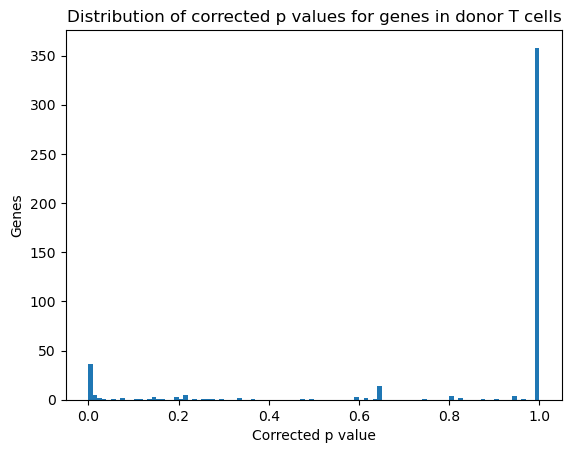

<Figure size 640x480 with 0 Axes>

In [99]:
# bar plot the p_val_corrected
genes = np.linspace(1, len(df_pval_donor_T), len(df_pval_donor_T))
plt.hist(df_pval_donor_T['p_val_corrected'], bins=100)
plt.ylabel('Genes')
plt.xlabel('Corrected p value')
plt.title('Distribution of corrected p values for genes in donor T cells')
plt.show()
plt.savefig(path + 'p_val_corrected_donor_T.png')

In [56]:
# filter genes with corrected p value = 1
df_pval_donor_T_filtered = df_pval_donor_T[df_pval_donor_T['p_val_corrected'] != 1]
df_pval_donor_T_filtered

,gene,p_val,p_val_corrected
267,RARG,4.599518e-18,7.144585e-16
224,ZBTB6,2.030984e-18,7.144585e-16
309,ZSCAN29,4.131573e-18,7.144585e-16
73,NR2C2,1.888199e-17,1.881714e-15
185,ZBTB33,2.019006e-17,1.881714e-15
...,...,...,...
360,HOXB9,2.179234e-01,9.490868e-01
7,POU3F1,2.174435e-01,9.490868e-01
255,MXI1,2.138928e-01,9.490868e-01
196,PLAG1,2.125457e-01,9.490868e-01


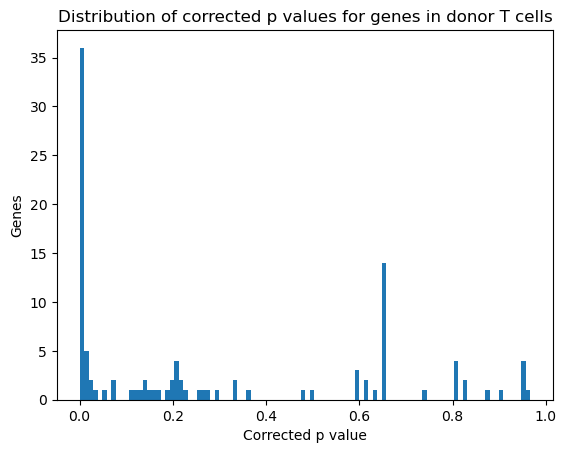

In [35]:
# bar plot the p_val_corrected
genes = np.linspace(1, len(df_pval_donor_T_filtered), len(df_pval_donor_T_filtered))
plt.hist(df_pval_donor_T_filtered['p_val_corrected'], bins=100)
plt.ylabel('Genes')
plt.xlabel('Corrected p value')
plt.title('Distribution of corrected p values for genes in donor T cells')
plt.show()

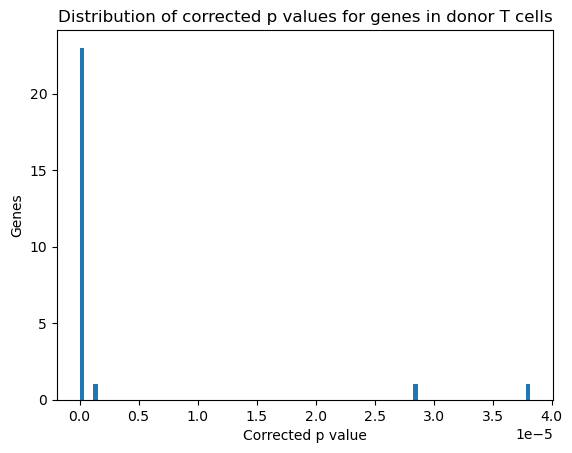

<Figure size 640x480 with 0 Axes>

In [100]:
df_pval_donor_T_filtered = df_pval_donor_T_filtered[df_pval_donor_T_filtered['p_val_corrected'] < 0.0001]
genes = np.linspace(1, len(df_pval_donor_T_filtered), len(df_pval_donor_T_filtered))
plt.hist(df_pval_donor_T_filtered['p_val_corrected'], bins=100)
plt.ylabel('Genes')
plt.xlabel('Corrected p value')
plt.title('Distribution of corrected p values for genes in donor T cells')
plt.show()
plt.savefig(path + 'p_val_corrected_donor_T_filtered.png')

In [58]:
top_genes_donor_T = df_pval_donor_T_filtered[df_pval_donor_T_filtered['p_val_corrected'] < 1e-5]
top_genes_donor_T.shape

(24, 3)

In [85]:
# find df_donor_T columns that correspond to the top genes, keep condition
df_donor_T_top_genes = df_donor_T[top_genes_donor_T['gene']]
df_donor_T_top_genes['condition'] = df_donor_T['condition']
# move condition column to the front
cols = df_donor_T_top_genes.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_donor_T_top_genes = df_donor_T_top_genes[cols]
df_donor_T_top_genes #final top gene result

/var/folders/ms/kqznsr6n6934_wtng0twy8dw0000gn/T/ipykernel_7660/4042308977.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_donor_T_top_genes['condition'] = df_donor_T['condition']


,condition,RARG,ZBTB6,ZSCAN29,NR2C2,ZBTB33,ZNF354A,HIC2,KLF7,ZNF684,...,ZNF211,ZNF669,ZNF324,LBX2,ATF6,SOX9,TEAD1,SOX8,HOXB6,NFYB
patient_ID,,,,,,,,,,,,,,,,,,,,,
1,NPC,34.0,47.0,18.0,48.0,56.0,51.0,15.0,18.0,28.0,...,78.0,74.0,51.0,1.0,114.0,0.0,1.0,0.0,0.0,116.0
2,NPC,36.0,81.0,39.0,138.0,76.0,58.0,27.0,59.0,59.0,...,93.0,86.0,86.0,3.0,197.0,3.0,0.0,1.0,4.0,298.0
3,NPC,47.0,67.0,26.0,73.0,55.0,41.0,18.0,41.0,37.0,...,91.0,55.0,55.0,1.0,164.0,3.0,2.0,2.0,1.0,238.0
4,NPC,36.0,41.0,32.0,63.0,52.0,35.0,8.0,35.0,42.0,...,49.0,59.0,41.0,2.0,131.0,2.0,1.0,0.0,1.0,125.0
5,NPC,50.0,42.0,24.0,89.0,59.0,32.0,14.0,26.0,45.0,...,48.0,66.0,44.0,2.0,105.0,5.0,0.0,2.0,1.0,179.0
9,NPC,173.0,170.0,116.0,281.0,186.0,263.0,76.0,290.0,168.0,...,345.0,302.0,309.0,11.0,556.0,346.0,0.0,1.0,7.0,635.0
10,NPC,94.0,101.0,54.0,174.0,105.0,114.0,38.0,90.0,119.0,...,135.0,203.0,192.0,9.0,352.0,7.0,1.0,0.0,3.0,332.0
11,NLH,122.0,53.0,29.0,99.0,82.0,120.0,63.0,50.0,61.0,...,138.0,185.0,171.0,4.0,289.0,1.0,3.0,3.0,0.0,194.0
12,NLH,136.0,71.0,33.0,103.0,92.0,72.0,34.0,50.0,69.0,...,162.0,159.0,168.0,0.0,255.0,0.0,3.0,5.0,1.0,269.0


In [102]:
# save the top genes to a tsv file
df_donor_T_top_genes.to_csv(path + 'NPC_NLH_donor_T_top_genes.tsv', sep='\t')
top_genes_donor_T.to_csv( path + 'NPC_NLH_donor_T_top_genes_ranking.tsv', sep='\t')

heatmap

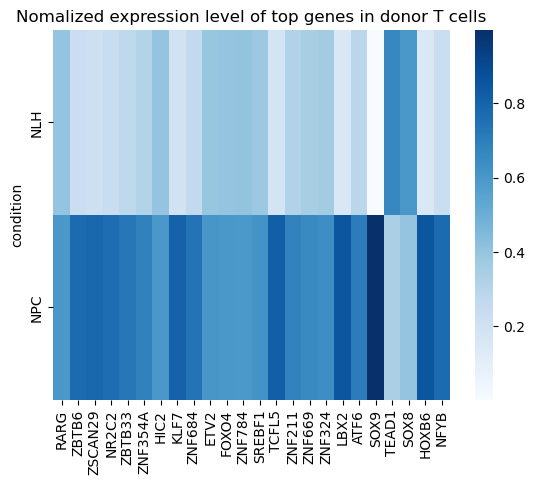

<Figure size 640x480 with 0 Axes>

In [103]:
# sum the counts of the top genes for condition NPC and NLH, normalize each gene

df_donor_T_top_genes_heatmap = df_donor_T_top_genes.groupby('condition').sum()
df_donor_T_top_genes_heatmap = df_donor_T_top_genes_heatmap.div(df_donor_T_top_genes_heatmap.sum(axis=0), axis=1)

# heatmap
sns.heatmap(df_donor_T_top_genes_heatmap, cmap='Blues')
plt.title('Nomalized expression level of top genes in donor T cells')
plt.show()
plt.savefig(path + 'top_genes_donor_T_heatmap.png')

In [94]:
df_donor_T_top_genes_heatmap

,RARG,ZBTB6,ZSCAN29,NR2C2,ZBTB33,ZNF354A,HIC2,KLF7,ZNF684,ETV2,...,ZNF211,ZNF669,ZNF324,LBX2,ATF6,SOX9,TEAD1,SOX8,HOXB6,NFYB
condition,,,,,,,,,,,,,,,,,,,,,
NLH,0.399745,0.224576,0.21374,0.239016,0.275523,0.310905,0.402439,0.196839,0.262222,0.392996,...,0.315661,0.346986,0.361772,0.147059,0.293013,0.002725,0.666667,0.6,0.15,0.230184
NPC,0.600255,0.775424,0.78626,0.760984,0.724477,0.689095,0.597561,0.803161,0.737778,0.607004,...,0.684339,0.653014,0.638228,0.852941,0.706987,0.997275,0.333333,0.4,0.85,0.769816
